In [17]:
import glob
from osgeo import gdal, ogr, osr
import geopandas as gpd
import pandas as pd
import sys, os
sys.path.append('/home/pmontesa/code/dgtools')
sys.path.append('/home/pmontesa/code/pygeotools')
import pygeotools 

sys.path.append('/home/pmontesa/code/geoscitools')
import footprintlib

# This is a private repo
from dgtools.lib import dglib

import matplotlib.pyplot as plt
import numpy as np

import contextily as ctx

# Here is all the SRLite input

In [3]:
maindir_toa = '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input'
dir_list_toa = glob.glob(maindir_toa +  '/*/')
dir_list_toa

['/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/RailroadValley/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Howland/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Laselva/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Siberia/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Yukon_Delta/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Senegal/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Whitesands/',
 '/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Serc/']

In [4]:
maindir_sr = '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all'
dir_list_sr = glob.glob(maindir_sr +  '/*/')
dir_list_sr

['/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Whitesands/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Howland/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Laselva/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/RailroadValley/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Senegal/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Serc/',
 '/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Siberia/']

### Functions

In [26]:
import pandas as pd
import xml.etree.ElementTree as et

def get_vhr_xml_image_attribute(xml_fn, ATTRIB_NAME):
    xtree = et.parse(xml_fn)
    xroot = xtree.getroot()
    return(xroot.find('IMD').find('IMAGE').find(ATTRIB_NAME).text)

def get_vhr_xml_band_attribute(xml_fn, BAND_NAME, ATTRIB_NAME):
    xtree = et.parse(xml_fn)
    xroot = xtree.getroot()
    return(xroot.find('IMD').find(BAND_NAME).find(ATTRIB_NAME).text)

def make_vhr_xml_dataframe(xml_fn: str, 
                  BAND_FOR_BOUNDS = 'BAND_N',
                  CORNER_COLS_LIST = ['ULLON','ULLAT','ULHAE','URLON','URLAT','URHAE','LLLON','LLLAT','LLHAE','LRLON','LRLAT','LRHAE'],
                  DF_COLS_LIST: list = ['SATID','CATID','TLCTIME','MEANPRODUCTGSD', 'MEANSUNAZ','MEANSATEL','MEANSATAZ','MEANSATEL','MEANINTRACKVIEWANGLE','MEANCROSSTRACKVIEWANGLE','MEANOFFNADIRVIEWANGLE','CLOUDCOVER','SCANDIRECTION']):
    
    '''Read the XML of a VHR image and return a dataframe of its metadata
    '''
    #print(xml_fn)
    xtree = et.parse(xml_fn)
    xroot = xtree.getroot()
    for child in xroot:
        #print(child.tag, child.attrib)
        if 'IMD' in child.tag:
            #print(child.tag, child.attrib)
            for child_1 in child:
                if BAND_FOR_BOUNDS == child_1.tag:
                    for child_2 in child_1:
                        if CORNER_COLS_LIST[0] in child_2.tag:
                            df1 = pd.DataFrame([get_vhr_xml_band_attribute(xml_fn, BAND_FOR_BOUNDS, COL) for COL in CORNER_COLS_LIST] ).transpose()
                            df1.columns = CORNER_COLS_LIST
                if 'IMAGE' == child_1.tag:
                    #print(child_1.tag, child_1.attrib)
                    for child_2 in child_1:
                        if DF_COLS_LIST[0] in child_2.tag:
                            #print(child_2.tag, child_2.attrib)
                            df2 = pd.DataFrame([get_vhr_xml_image_attribute(xml_fn, COL) for COL in DF_COLS_LIST] ).transpose()
                            df2.columns = DF_COLS_LIST
    return(pd.concat([df2, df1], axis=1))

def MAKE_DIR_POLAR_PLOT(d_list, indir):
    '''Make a polar plot of the acquisition characteristics of the sun and the sensor for a list of .xml files
    '''
    
    #plot_list = []
    
    f = plt.figure(figsize=(7,5))
    ax = plt.subplot(111, projection='polar')
    ax.set_theta_direction(-1)
    ax.set_theta_zero_location('N')
    # And a corresponding grid
    #ax.grid(which='both')
    #ax.grid(which='minor', alpha=0.02)
    ax.grid(which='major', alpha=0.5, linestyle='--')


    colors = {'QB02':'tab:pink', 'GE01':'tab:green', 'WV01':'tab:blue', 'WV02':'tab:red', 'WV03':'tab:purple'}

    # title = p['pairname']
    # title += '\nCenter datetime: %s' % p['cdate']
    # title += '\nTime offset: %0.2f s' % abs(p['dt'].total_seconds())
    # title += '\nConv. angle: %0.2f, Int. area: %0.2f km2' % (p['conv_ang'], p['intersection_area'])
    # title += '\n%s gsd:%0.2f az:%0.1f el:%0.1f off:%0.1f %s %i' % (p['id1_dict']['id'], p['id1_dict']['gsd'], p['id1_dict']['az'], (90-p['id1_dict']['el']), p['id1_dict']['offnadir'], p['id1_dict']['scandir'], p['id1_dict']['tdi'])
    # title += '\n%s gsd:%0.2f az:%0.1f el:%0.1f off:%0.1f %s %i' % (p['id2_dict']['id'], p['id2_dict']['gsd'], p['id2_dict']['az'], (90-p['id2_dict']['el']), p['id2_dict']['offnadir'], p['id2_dict']['scandir'], p['id2_dict']['tdi'])

    # title = d['id']
    # title += '\nCenter datetime: %s' % d['date']
    # title += '\n%s gsd:%0.2f az:%0.1f el:%0.1f off:%0.1f %s %i' % (d['id'], d['gsd'], d['az'], (90-d['el']), d['offnadir'], d['scandir'], d['tdi'])

    title = f'Acquisition geometry of SRLite input'
    title += f"\n{indir.split('nobackup/')[-1]}"

    # Mark the target at the center of the polar plot
    ax.plot(0,0,marker='+',color='k')
    
    marker_kwargs = {'marker':'o', 'alpha': 0.75}

    for d in d_list:
        
        # Make a df b/c its easier to handle during plotting of cmaps
        #df = pd.DataFrame([d])

        # Map colors to sensor like this?
        ax.plot(np.radians(d['az']), (90-d['el']), markersize=3, \
                #label='ID1', \
                c='k',
                # To map color to each sensor
                #c=pd.DataFrame([d])['sensor'].map(colors)[0], \
                **marker_kwargs   )
        # or
        #ax.plot(np.radians(df['az']), (90-df['el']), markersize=3, column=df['sensor'], categorical=True, **marker_kwargs ) #categorical=True, legend=True, cmap='viridis', 
       
        # Add the Sun positions
        ax.plot(np.radians(d['sunaz']), (90-d['sunel']), markersize=10, label='Sun', c='orange', mfc='none', **marker_kwargs )
        #ax.plot(np.radians(p['id2_dict']['az']), (90-p['id2_dict']['el']), marker='o', label='ID2')
        #ax.plot([np.radians(p['id1_dict']['az']), np.radians(p['id2_dict']['az'])], [90-p['id1_dict']['el'], 90-p['id2_dict']['el']], \
        #       color='k', ls=':')

        #ax.legend()

        #This sets elevation range
        ax.set_rmin(0)
        ax.set_rmax(90)
        #ax.patch.set_facecolor('lightgray')

        ax.set_title(title, fontsize=10)
        
        #plot_list.append(ax)
        
    plt.tight_layout()
    
    # TODO: how do i return the ax so that I can place the figure I just made with other figures..
    return ax

def MAP_FOOTPRINTS(gdf, COL_NAME):
    
    fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    #colors = {'TOA':'tab:red', 'SR':'tab:green'}
    #colors = {'QB02':'tab:pink', 'GE01':'tab:green', 'WV01':'tab:blue', 'WV02':'tab:red', 'WV03':'tab:purple'}

    # Plot type
    #ax = footprints_gdf_ahri_20220818_adapt.plot(ax=ax, alpha=0.5, ec='k', column='sensor', label='file', categorical=True, legend=True, cmap='viridis')

    # Plot sensor of SR
    ax1 = gdf.to_crs(4326).cx[-180:-125,50:75].plot(ax=ax1, alpha=0.75, ec='k', column=COL_NAME, categorical=True, legend=True, cmap='coolwarm')


    ax1 = ctx.add_basemap(ax1, crs=4326, 
        #source = ctx.providers.Gaode.Satellite
        #source = ctx.providers.Esri.WorldShadedRelief
        source = ctx.providers.Esri.WorldGrayCanvas
        #source = ctx.providers.Esri.NatGeoWorldMap
        #source = ctx.providers.Esri.WorldImagery
        #source = ctx.providers.Esri.DeLorme
    )

#### Make a dataframe of metadata 

In [6]:
#pd.concat([make_vhr_xml_dataframe(f) for f in f_list])
#pd.concat([make_vhr_xml_dataframe(xml_fn) for xml_fn in f_list[0:3]])

### Make a dictionary of VHR metadata
Use dgtools to pull out metadata for list of TOAs in a dir

In [7]:
indir = dir_list_toa[1]
id_list = dglib.dir_ids(indir)
print(id_list[0])
d_list = [dglib.get_id_dict(indir, id) for id in id_list]

1020010004D37600


In [8]:
d_list[0]

{'id': '1020010004D37600',
 'sensor': 'WV01',
 'date': datetime.datetime(2008, 10, 11, 15, 31, 13, 772292),
 'alt': 496.0,
 'az': 104.4,
 'el': 74.6,
 'sunaz': 164.4,
 'sunel': 36.5,
 'gsd': 0.53,
 'scandir': 'Reverse',
 'tdi': 16,
 'offnadir': 14.3,
 'intrack': -1.0,
 'crosstrack': 14.2,
 'cloudcover': 0.0,
 'geom': <osgeo.ogr.Geometry; proxy of <Swig Object of type 'OGRGeometryShadow *' at 0x14d0552f3510> >,
 'geom_poly': <shapely.geometry.polygon.Polygon at 0x14d0552f8070>,
 'stereopair': None}

In [9]:
# from itertools import groupby

# print([{"name": key, "data": [(g['id'], g['gsd']) for g in group]} 
#        for key, group in groupby(d_list, lambda x: x['sensor'])])

In [10]:
# for key, group in groupby(d_list, lambda x: x['sensor']):
#     print(key)

### Plot view geom of acquisition
reference:  
https://github.com/dshean/dgtools/blob/master/notebooks/dg_pair_geom_eph_analysis.ipynb

In [11]:
os.path.split(indir)[-2]
indir

'/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Howland/'

In [12]:
if False:
    
    exclude_list = ['Yukon_Delta']

    for indir in dir_list:

        indir = indir.rstrip('/')
        print(os.path.basename(indir))

        if os.path.basename(indir) not in exclude_list:  

            id_list = dglib.dir_ids(indir)
            print(len(id_list))

            # Get list of dictionaries of metadata for each VHR image
            d_list = [dglib.get_id_dict(indir, id) for id in id_list if not str(id).startswith('101')]

            returned_stuff = MAKE_DIR_POLAR_PLOT(d_list, indir)

Acquisition geometry should be something that helps explain poor SRLite results. We can add to the assessment tools batch polar plotting to visualize the variation in acquisitions within a batch

In [13]:
TARGET = 'Alaska'

In [14]:

# [indir for indir in dir_list_toa if TARGET in indir][0]

### Build footprint gdf for TARGET

##### TOA

In [15]:
TARGET_DIR_TOA = [indir for indir in dir_list_toa if TARGET in indir][0]

# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)
f_list_toa =glob.glob(f'{TARGET_DIR_TOA}/*toa.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_toa]
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa['type'] = 'TOA'
footprint_gdf_toa['name'] = footprint_gdf_toa['file'].str.split('-toa', expand=True)[0]

footprint_gdf_toa.head()

/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska
Building GDF from list...


,geometry,footprint_name,path,file,area_km2,area_ha,type,name
0,"POLYGON ((-153.19679 60.95999, -153.20363 62.0...",None,/panfs/ccds02/nobackup/projects/ilab/projects/...,WV02_20180912_M1BS_1030010082C72A00-toa.tif,2314.996848,231499.6848,TOA,WV02_20180912_M1BS_1030010082C72A00
1,"POLYGON ((-145.69633 60.10356, -145.65810 61.0...",None,/panfs/ccds02/nobackup/projects/ilab/projects/...,WV02_20160708_M1BS_1030010059015800-toa.tif,2257.943856,225794.3856,TOA,WV02_20160708_M1BS_1030010059015800
2,"POLYGON ((-163.93624 61.96512, -163.88696 63.3...",None,/panfs/ccds02/nobackup/projects/ilab/projects/...,WV03_20190612_M1BS_104001004D5E6B00-toa.tif,2748.683200,274868.3200,TOA,WV03_20190612_M1BS_104001004D5E6B00
3,"POLYGON ((-155.95984 67.95610, -155.81543 69.0...",None,/panfs/ccds02/nobackup/projects/ilab/projects/...,GE01_20200602_M1BS_105001001D902200-toa.tif,2584.433116,258443.3116,TOA,GE01_20200602_M1BS_105001001D902200
4,"POLYGON ((-145.03233 61.97477, -144.96139 63.0...",None,/panfs/ccds02/nobackup/projects/ilab/projects/...,WV02_20170718_M1BS_103001006E4B9400-toa.tif,3049.457892,304945.7892,TOA,WV02_20170718_M1BS_103001006E4B9400


##### SR

In [16]:
TARGET_DIR_SR = [indir for indir in dir_list_sr if TARGET in indir][0]

# Get footprints gdf from a target dir
TARGET_DIR_SR = TARGET_DIR_SR.rstrip('/')
print(TARGET_DIR_SR)
f_list_sr =glob.glob(f'{TARGET_DIR_SR}/*sr*.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_sr]
footprint_gdf_sr = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_sr['type'] = 'SR'
footprint_gdf_sr['name'] = footprint_gdf_sr['file'].str.split('-sr', expand=True)[0]
footprint_gdf_sr.head()

/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska
Building GDF from list...


,geometry,footprint_name,path,file,area_km2,area_ha,type,name
0,"POLYGON ((-161.92532 64.96236, -161.77901 66.1...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,GE01_20140705_M1BS_1050410010CD1600-sr-02m.tif,3414.198348,341419.8348,SR,GE01_20140705_M1BS_1050410010CD1600
1,"POLYGON ((-156.92812 57.97207, -156.83266 59.5...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,GE01_20190921_M1BS_1050010018B75900-sr-02m.tif,4179.120912,417912.0912,SR,GE01_20190921_M1BS_1050010018B75900
2,"POLYGON ((-155.96861 61.93846, -155.85629 63.0...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,GE01_20150731_M1BS_1050010001163300-sr-02m.tif,2794.825880,279482.5880,SR,GE01_20150731_M1BS_1050010001163300
3,"POLYGON ((-163.47371 61.21269, -163.43302 62.0...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,GE01_20190604_M1BS_1050010016916600-sr-02m.tif,1851.444864,185144.4864,SR,GE01_20190604_M1BS_1050010016916600
4,"POLYGON ((-153.44236 67.14746, -153.47337 68.7...",None,/explore/nobackup/projects/ilab/data/srlite/pr...,GE01_20160801_M1BS_105001000598DB00-sr-02m.tif,3388.859404,338885.9404,SR,GE01_20160801_M1BS_105001000598DB00


### Join gdfs

In [17]:
footprint_gdf = pd.merge(footprint_gdf_sr, footprint_gdf_toa[['file', 'name', 'path']], how='inner', left_on = 'name', right_on = 'name', copy=False)
# concat
#footprint_gdf = pd.concat([footprint_gdf_toa, footprint_gdf_sr])

In [18]:
footprint_gdf['sensor'] = footprint_gdf['file_x'].str.split('_', expand=True)[0]
footprint_gdf['year'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[0:4].astype(int)
footprint_gdf['month'] = footprint_gdf['file_x'].str.split('_', expand=True)[1].str[4:6].astype(int)


#footprint_gdf[footprint_gdf.type == 'SR'].head()
#print( f"# TOA images: {footprint_gdf[footprint_gdf['type']  == 'TOA'].shape[0]}")
print( f"# SR images: {footprint_gdf[footprint_gdf['type'] == 'SR'].shape[0]}")

# SR images: 172


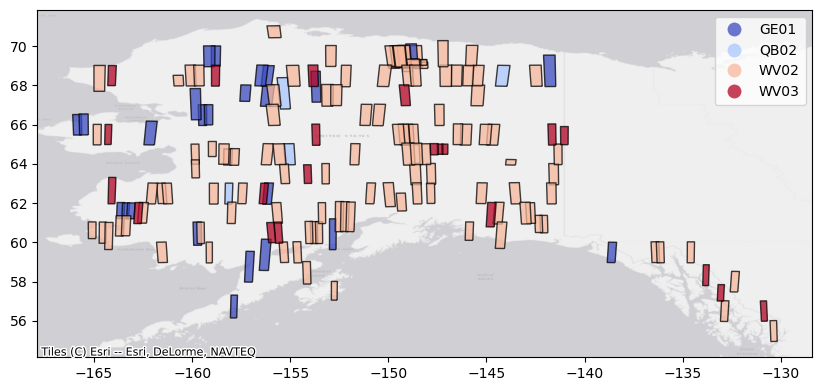

In [38]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
#colors = {'TOA':'tab:red', 'SR':'tab:green'}
#colors = {'QB02':'tab:pink', 'GE01':'tab:green', 'WV01':'tab:blue', 'WV02':'tab:red', 'WV03':'tab:purple'}

# Plot type
#ax = footprint_gdf.plot(ax=ax, alpha=0.5, ec='k', column='sensor', label='file', categorical=True, legend=True, cmap='viridis')

# Plot sensor of SR
ax1 = footprint_gdf[footprint_gdf['type']  == 'SR'].plot(ax=ax1, alpha=0.75, ec='k', column='sensor', categorical=True, legend=True, cmap='coolwarm')

#ax = target_footprint_gdf.boundary.plot(ax=ax, color='red')

#ax.legend(loc="upper left")
ax1 = ctx.add_basemap(ax1, crs=4326, 
    #source = ctx.providers.Gaode.Satellite
    #source = ctx.providers.Esri.WorldShadedRelief
    source = ctx.providers.Esri.WorldGrayCanvas
    #source = ctx.providers.Esri.NatGeoWorldMap
    #source = ctx.providers.Esri.WorldImagery
    #source = ctx.providers.Esri.DeLorme
)


In [21]:
id_list = dglib.dir_ids(TARGET_DIR_TOA)
TARGET_DIR_TOA

'/panfs/ccds02/nobackup/projects/ilab/projects/srlite/input/Alaska'

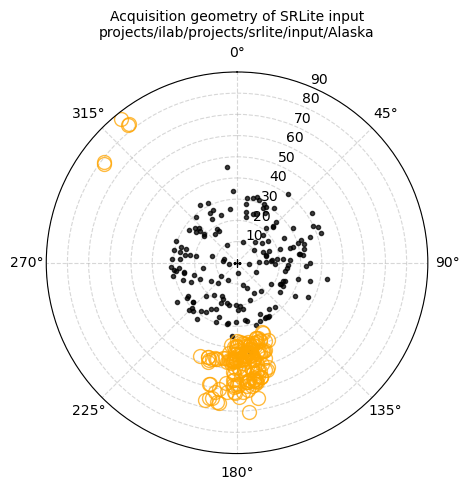

In [70]:
# Get list of dictionaries of metadata for each VHR image

d_list = [dglib.get_id_dict(TARGET_DIR_TOA, id) for id in id_list if not str(id).startswith('101')]
returned_thing = MAKE_DIR_POLAR_PLOT(d_list, TARGET_DIR_TOA)

In [206]:
TARGET_DIR_SR

'/explore/nobackup/projects/ilab/data/srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska'

# Build geodataframe of footprints and map

In [13]:
TARGET = 'Alaska_ahri_20221004'
TARGET_DIR_TOA = f'/explore/nobackup/projects/ilab/data/srlite/toa/{TARGET}/initial_output'

# Get footprints gdf from a target dir
TARGET_DIR_TOA = TARGET_DIR_TOA.rstrip('/')
print(TARGET_DIR_TOA)
f_list_toa =glob.glob(f'{TARGET_DIR_TOA}/**/5-toas/*toa.tif')
f_gdf_lst = [footprintlib.raster_footprint(r_fn, DO_DATAMASK=False, GET_ONLY_DATASETMASK=True, R_READ_MODE='r', MANY_CRS=True) for r_fn in f_list_toa]
footprint_gdf_toa = footprintlib.build_footprint_db(f_gdf_lst, TO_GCS=False, WRITE_GPKG=False, OUT_F_NAME='', OUT_LYR_NAME=TARGET, DROP_DUPLICATES=True)
footprint_gdf_toa['type'] = 'TOA'
footprint_gdf_toa['name'] = footprint_gdf_toa['file'].str.split('-toa', expand=True)[0]

footprint_gdf_toa['sensor'] = footprint_gdf_toa['file'].str.split('_', expand=True)[0]
footprint_gdf_toa['year'] = footprint_gdf_toa['file'].str.split('_', expand=True)[1].str[0:4].astype(int)
footprint_gdf_toa['month'] = footprint_gdf_toa['file'].str.split('_', expand=True)[1].str[4:6].astype(int)


#footprint_gdf[footprint_gdf.type == 'SR'].head()
#print( f"# TOA images: {footprint_gdf[footprint_gdf['type']  == 'TOA'].shape[0]}")
print( f"# {TARGET} images: {footprint_gdf_toa.shape[0]}")

footprint_gdf_toa.head()

# Alaska_ahri_20221004 images: 1822


,geometry,footprint_name,path,file,area_km2,area_ha,type,name,sensor,year,month
0,"POLYGON ((-131.32533 54.53738, -131.35315 55.0...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20190401_M1BS_10400100495FC500-toa.tif,969.170796,96917.0796,TOA,WV03_20190401_M1BS_10400100495FC500,WV03,2019,4
1,"POLYGON ((-129.66934 55.97045, -129.68837 57.0...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV02_20160620_M1BS_1030010056D76C00-toa.tif,2820.302820,282030.2820,TOA,WV02_20160620_M1BS_1030010056D76C00,WV02,2016,6
2,"POLYGON ((-130.56508 55.97504, -130.58476 56.4...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20190528_M1BS_104001004C137000-toa.tif,829.268136,82926.8136,TOA,WV03_20190528_M1BS_104001004C137000,WV03,2019,5
3,"POLYGON ((-130.73437 55.30028, -130.78138 56.3...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20180731_M1BS_104001003F6B9B00-toa.tif,2114.686080,211468.6080,TOA,WV03_20180731_M1BS_104001003F6B9B00,WV03,2018,7
4,"POLYGON ((-129.63771 54.96684, -129.65520 56.0...",None,/explore/nobackup/projects/ilab/data/srlite/to...,WV03_20190401_M1BS_104001004AB41000-toa.tif,2170.275072,217027.5072,TOA,WV03_20190401_M1BS_104001004AB41000,WV03,2019,4


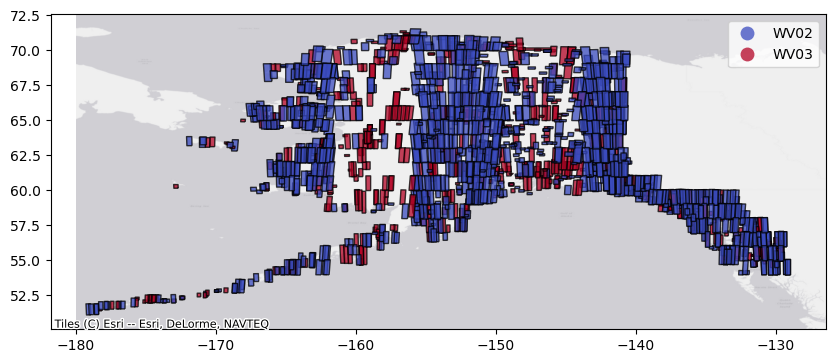

In [27]:
MAP_FOOTPRINTS(footprint_gdf_toa, 'sensor')

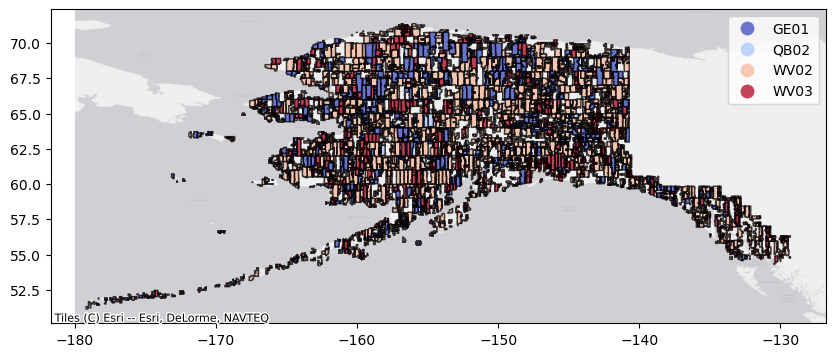

In [25]:
footprints_gdf_ahri_20220818_adapt = gpd.read_file('/explore/nobackup/people/mmacande/footprints/ahri_scenes_in_adapt_20220818.gpkg')
MAP_FOOTPRINTS(footprints_gdf_ahri_20220818_adapt, 'FIRST_sensor')

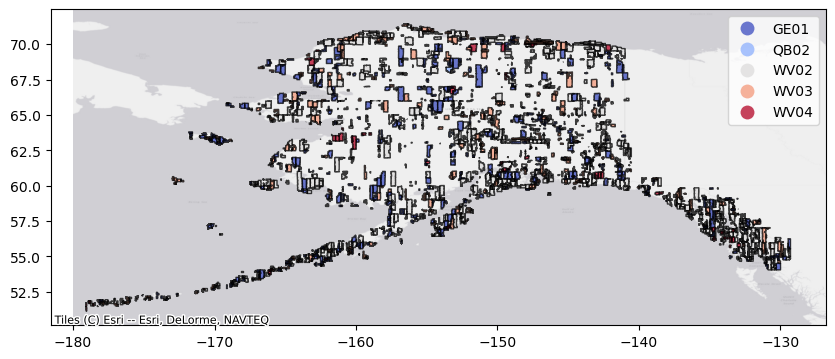

In [30]:
footprints_gdf_ahri_20220818_not_adapt = gpd.read_file('/explore/nobackup/people/mmacande/footprints/ahri_scenes_not_in_adapt_20220818.gpkg')
MAP_FOOTPRINTS(footprints_gdf_ahri_20220818_not_adapt, 'FIRST_sensor')